In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend
from PIL import Image
import pandas as pd

In [ ]:
test_data = pd.read_pickle('/content/drive/MyDrive/u-net/lung_cancer/extract_data/extracted_lung_cancer_test.pkl')
print(test_data.keys())

Index(['hu_array', 'mask'], dtype='object')


In [ ]:
# Hàm để thay đổi kích thước hình ảnh
def resize_images(images, size=(256, 256)):
    resized_images = []
    for idx, img in enumerate(images):
        if img is not None and img.size > 0:
            #print(f"Processing image {idx} with shape: {img.shape}")

            # Chuyển về kiểu int trước khi resize
            img = img.astype(np.uint8)
            resized_img = cv2.resize(img, size)

            # Chuyển về kiểu float sau khi resize
            resized_img = resized_img.astype('float32')
            resized_images.append(resized_img)
        else:
            print(f"Invalid image at index {idx} with shape: {img.shape if img is not None else 'None'}")
    return np.array(resized_images)

In [ ]:
# Hàm để tiền xử lý dữ liệu
def preprocess_data(data, resize_size=(256, 256)):
    hu_arrays = [np.array(image) for image in data['hu_array']]
    masks = [np.array(mask) for mask in data['mask']]

    # Convert lists to NumPy arrays
    hu_arrays = np.array(hu_arrays)
    masks = np.array(masks)

    # Normalize HU arrays
    hu_arrays = hu_arrays.astype('float32') / 255.0

    # Expand dimensions to match the expected input shape (batch, height, width, channels)
    hu_arrays = np.expand_dims(hu_arrays, axis=-1)
    masks = np.expand_dims(masks, axis=-1)

    # Resize the images and masks
    hu_arrays = resize_images(hu_arrays, size=resize_size)
    masks = resize_images(masks, size=resize_size)

    return hu_arrays, masks

In [ ]:
test_images, test_masks = preprocess_data(test_data)

In [ ]:
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")

Test images shape: (264, 256, 256)
Test masks shape: (264, 256, 256)


In [ ]:
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + smooth)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
# Load the pre-trained model
model = load_model(r'/content/drive/MyDrive/u-net/deploy/best_04-08-2024.keras', custom_objects={'iou': iou, 'dice_coef': dice_coef})
# Biên dịch lại mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou, dice_coef])
print(model)

<Functional name=functional, built=True>


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
CT image:  151


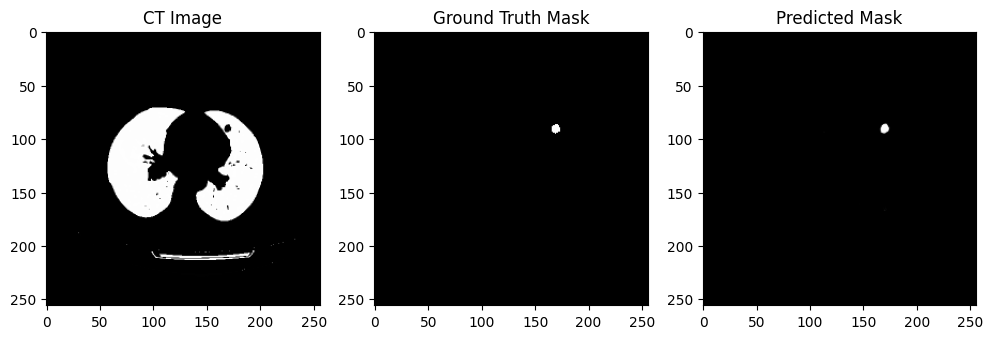

In [ ]:
# Predict on a sample test image
# Chọn một ảnh ngẫu nhiên để dự đoán
import random
random_index = random.randint(0, len(test_images) - 1)
sample_image = test_images[random_index]
sample_mask = test_masks[random_index]
predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))

print("CT image: ", random_index)
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("CT Image")
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.show()

In [ ]:
def preprocess_single_image(image_path, resize_size=(256, 256)):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None or image.size == 0:
        raise ValueError("Invalid image at path: {}".format(image_path))

    # Thay đổi kích thước ảnh
    resized_image = cv2.resize(image, resize_size)

    # Chuyển ảnh sang ảnh nhị phân bằng cách sử dụng ngưỡng
    _, binary_image = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY)

    # Đảo ngược màu của ảnh nhị phân
    inverted_binary_image = cv2.bitwise_not(binary_image)

    return inverted_binary_image

In [ ]:
# Đường dẫn tới ảnh muốn xử lý
image_path1 = '/content/drive/MyDrive/u-net/lung_cancer/img_test/img1.jpg'
image_path2 = '/content/drive/MyDrive/u-net/lung_cancer/img_test/img2.jpg'

Shape of inverted binary image: (256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


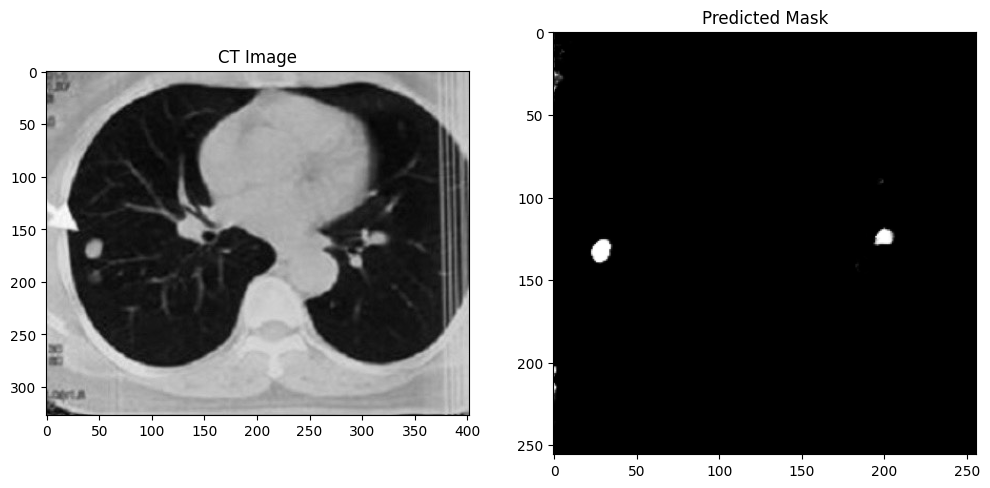

In [ ]:

# Tiền xử lý ảnh
inverted_binary_image = preprocess_single_image(image_path1, resize_size=(256, 256))

# Kiểm tra hình dạng của ảnh đã tiền xử lý
print("Shape of inverted binary image:", inverted_binary_image.shape)

# Hiển thị ảnh gốc và ảnh nhị phân đã đảo ngược màu
original_image = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)

predicted_mask = model.predict(np.expand_dims(inverted_binary_image, axis=0))
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("CT Image")
plt.imshow(original_image.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.show()

Shape of inverted binary image: (256, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


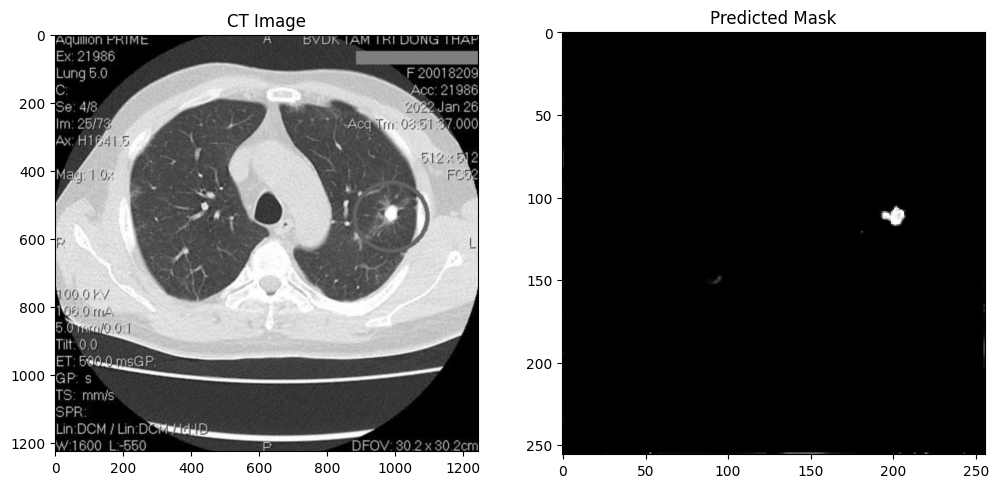

In [ ]:
inverted_binary_image = preprocess_single_image(image_path2, resize_size=(256, 256))

# Kiểm tra hình dạng của ảnh đã tiền xử lý
print("Shape of inverted binary image:", inverted_binary_image.shape)

# Hiển thị ảnh gốc và ảnh nhị phân đã đảo ngược màu
original_image = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

predicted_mask = model.predict(np.expand_dims(inverted_binary_image, axis=0))
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("CT Image")
plt.imshow(original_image.squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.show()